In [1]:
import glob
from math import ceil
from keras.models import load_model
from keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image 
import pickle

## Save the path of the dataset 

In [2]:
PATH = os.getcwd() 
train_path = PATH+'/dataset/' 

## Below function returns the label/file name of the image

In [3]:
def get_label(name):
    if name:
        img_name = name.split("/dataset/")
        img_name = img_name[1].split(".jpg")
        return img_name[0]
    return None

## Finding labels of all the images in our dataset

In [4]:
img_path = './dataset/*.jpg'
images = glob.glob(img_path)
labels = []
k=0
for img in images:
    # get the image unique id and set it as the label
    label_id = get_label(img)
    labels.append(label_id)
    k += 1

## Splitting training and test dataset
80% of the data is used for training and 20% of the data is used for testing

In [5]:
length=int((len(labels)*80/100))
train_sample = images[0:length]
train_label= labels[0:length]
test_sample=images[length:len(labels)]
test_label=labels[length:len(labels)]
print("no.of images in train set:", len(train_sample))
print("no.of images in test set:", len(test_sample))

no.of images in train set: 3790
no.of images in test set: 948


## Function to retreive similar images  from dataset as that of the test_image:
the below function takes as input the trained codes, test image and label. Test code for the test image is predicted and the distance between the test code and each trained code is computed and based the distance, indexes of the top "N" closed images are returned.

trained_codes: output of the encoder layer for all the training images

test_codes: output of the encoder image for the test_image

In [6]:
def retrieve_closest_images(trained_codes, test_element, test_label, n_samples):
    # reshape the trained codes
    trained_codes = trained_codes.reshape(trained_codes.shape[0], trained_codes.shape[1]*trained_codes.shape[2]*trained_codes.shape[3])
    
    # predict the encoder layer codes for the test image
    test_codes = encoder.predict(np.array([test_element]))
    # reshape the tested codes of the test image
    test_codes = test_codes.reshape(test_codes.shape[1]*test_codes.shape[2]*test_codes.shape[3])
    
    # initialize the distance list
    distances = []

    for code in trained_codes:
        # for each code of the training images, compute the Euclidean distance between the train image and test image
        distance = np.linalg.norm(code - test_codes)
        distances.append(distance)# append to the distance list
            

    nb_elements = trained_codes.shape[0] # get the total number of images in the training set
    distances = np.array(distances) # convert the distance list to a numpy array
    trained_code_index = np.arange(nb_elements) # creae an index list from 0 - nb_elements
    
    # create a numpy stack with the distances, index_list
    distance_with_index = np.stack((distances, trained_code_index), axis=-1)
    sorted_distance_with_index = distance_with_index[distance_with_index[:,0].argsort()] # sort the stack
    sorted_distances = sorted_distance_with_index[:, 0].astype('float32') # change the datatype
    sorted_indexes = sorted_distance_with_index[:, 1]
    kept_indexes = sorted_indexes[:n_samples] # Get the first N indexes of the sorted_indexes list

    return kept_indexes

## Initialize width, height, train and test batch size as required

In [7]:
width = 224 #Given images are of 512*512 shape
height = 224
train_batch_size = 20
test_batch_size = 10
train_size=len(train_sample)
test_size=len(test_sample)
# define the batch lists with the batch sizes
train_list = list(range(int(ceil(float(train_size) / train_batch_size))))
test_list = list(range(int(ceil(float(test_size) / test_batch_size))))

## loding the model that is saved after training

In [8]:
autoencoder = load_model('autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output) 

## Run the below cell which predicts the output of the encoder layer for all the training images and stored in the variable trained_codes
## Note: skip below 2 cells if the trained_codes are already predicted and saved

In [ ]:
trained_codes = np.array([], dtype='float32').reshape(0,28,28, 8) # initialize the training codes

# predict the encoder layer features for the training dataset
for n, i in enumerate(train_list):
    i_s = i * train_batch_size
    i_e = min([(i + 1) * train_batch_size, train_size])
    train_images=[]
    train_labels=[]
    for j in range(i_s,i_e):
        img_addr = train_sample[j]
        img = cv2.imread(img_addr)
        img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
        img_lbl = get_label(img_addr) # get the unique ID
        train_images.append(img) # append the images
        img_lbl = np.array([img_lbl]) 
        train_labels.append(img_lbl) # append the labels
    x_train=np.array(train_images, dtype=np.float32)/255.
    y_train = train_labels
    print('predicting for ', i_s, ' to ', i_e, '\n')
    predicted_codes = encoder.predict(x_train)
    trained_codes = np.concatenate((trained_codes, predicted_codes))


## saving the trained_codes for further use

In [ ]:
filename = "train_codes.sav"
pickle.dump(trained_codes, open(filename, 'wb'))

## Run the below cell to load the trained_codes if they are already predicted and saved by running above 2 cells 

In [9]:
trained_codes = pickle.load(open('train_codes.sav', 'rb'))

## Below function is used to plot the images in a grid format (sub plots)

In [10]:
def plot_images(result):
    w=20
    h=20
    fig=plt.figure(figsize=(50, 50))
    columns = 3
    rows = ceil(len(result)/columns)
    for i in range(1, columns*rows +1):
        if i==len(result)+1:
            break
        temp=str(result[i-1])+".jpg"
        img_path = train_path+temp 
        x = image.load_img(img_path)
        fig.add_subplot(rows, columns, i)
        #plt.axis("off")
        plt.imshow(x)
    plt.show()

## Test Model:
test_model reads images from test sample and normalize it.
Further it send trained codes(output of encoder layer fo all training images),test image, test label to retrieve_closest_images function which predicts and returns indexes of top N closest images

In [11]:
def test_model(test_size,test_sample,width,height):
    test_images=[]
    test_labels=[]
    N=10
    # enumerate over the test images
    for j in range(test_size):
        img_addr = test_sample[j]
        img = cv2.imread(img_addr)
        #when cv2 read the image it it converted to BGR image so to display the original image again converting back to RGB
        img_display = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.axis("off")
        plt.imshow(img_display)    
        img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
        img_lbl = get_label(img_addr) # get the unique ID
        test_images.append(img) # append the images
        img_lbl = np.array([img_lbl]) 
        test_labels.append(img_lbl) # append the labels
        x_test=np.array(img, dtype=np.float32)/255.
        y_test = test_labels
        similar_indexes = retrieve_closest_images(trained_codes, x_test, y_test,N) # retrieve the indexes closest images for the give test image
        similar_indexes = similar_indexes.astype('int')
        temp= len(similar_indexes)/2
        result=[]
        for i in similar_indexes:
            result.append(labels[i])
        plot_images(result)

In [ ]:
test_model(test_size,test_sample,width,height)

# Testing your own image
User need to give either the path of the image or the label of the image as input and the below function predicts top N closest images

In [12]:
def test_your_image(random,train_path,width,height,labels,N):
    if len(random)<=4:
        img_path = train_path+random+".jpg" 
    else:
        img_path=random
    #img_addr = image.load_img(img_path)
    img = cv2.imread(img_path)
    #when cv2 read the image it it converted to BGR image so to display the original image again converting back to RGB
    img_display = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #plt.axis("off")
    plt.imshow(img_display)   
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    img_lbl = get_label(img_path) # get the unique ID
    x_test=np.array(img, dtype=np.float32)/255.
    y_test = img_lbl
    similar_indexes = retrieve_closest_images(trained_codes, x_test, y_test,N) # retrieve the indexes closest images for the give test image
    similar_indexes = similar_indexes.astype('int')
    temp= len(similar_indexes)/2
    result=[]
    for i in similar_indexes:
        result.append(labels[i])
    plot_images(result)

## Enter a number from 1 to 4500 or give the path of the image

enter a number from 1 to 4500 or give the path of the image:3


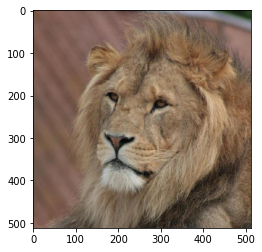

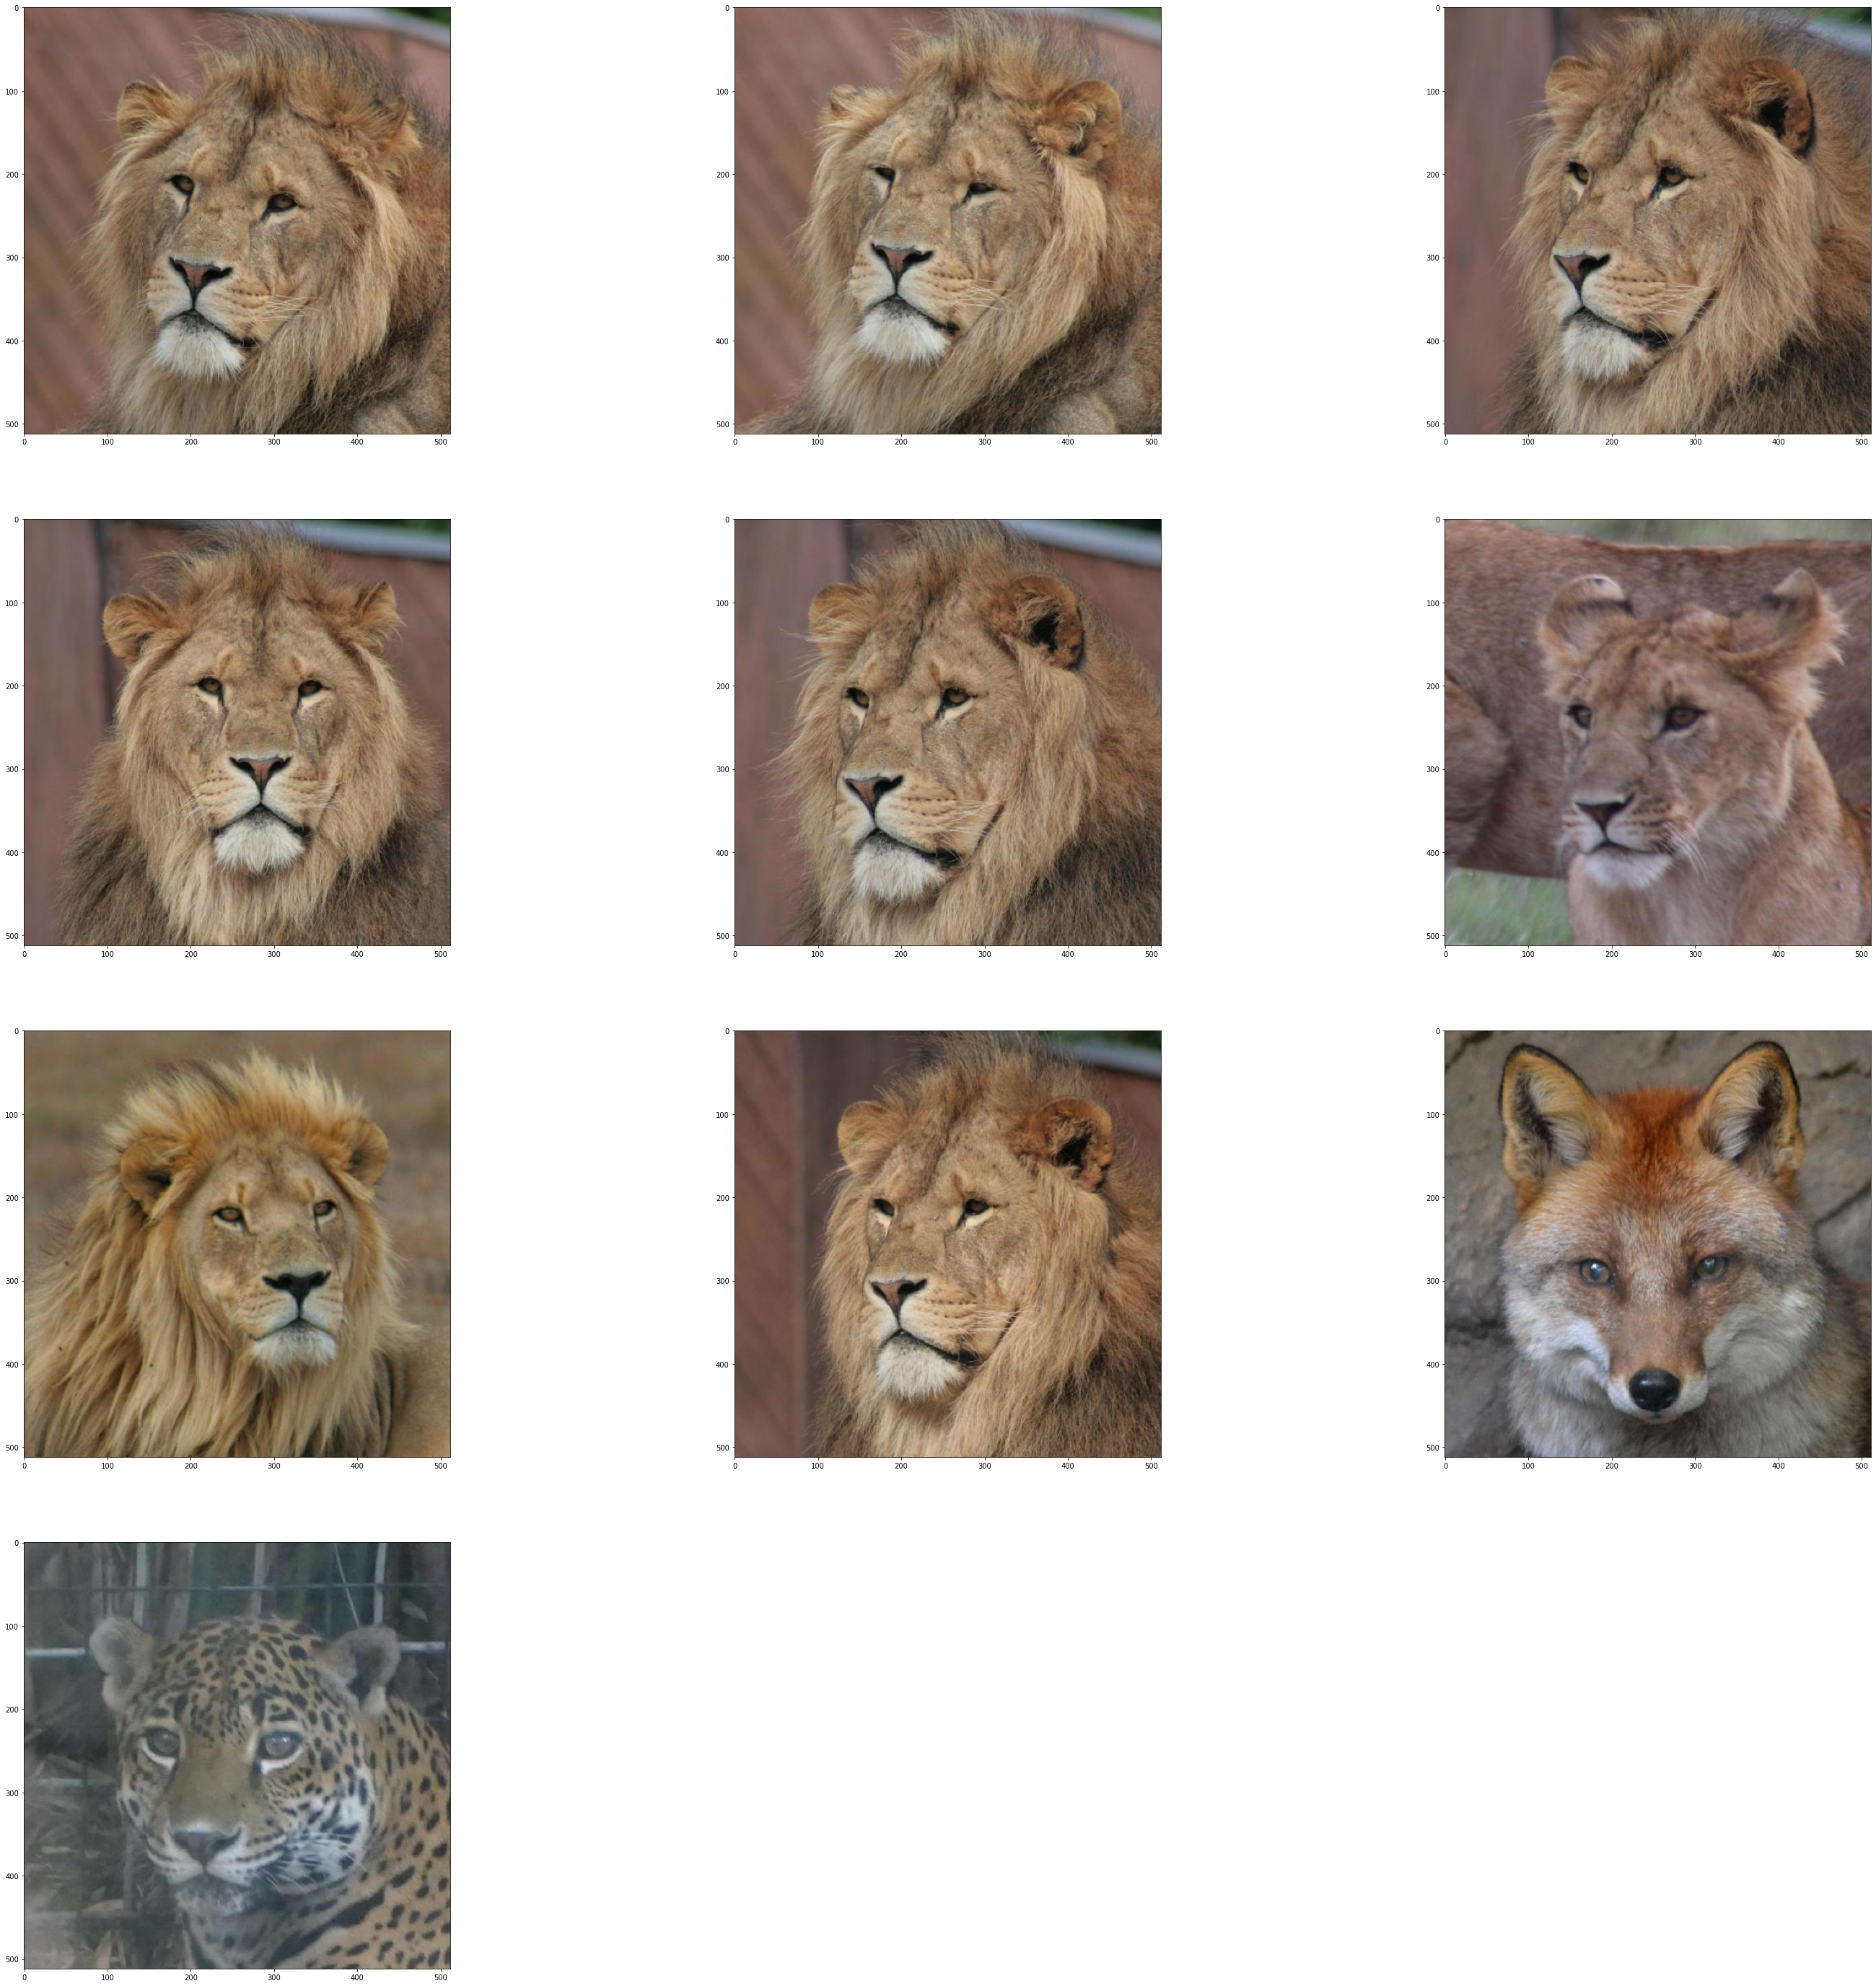

In [15]:
N=10
random=input("enter a number from 1 to 4500 or give the path of the image:")
test_your_image(random,train_path,width,height,labels,N)